# Modeling

In [54]:
# Imports
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
import sklearn.linear_model as skl
import sklearn.model_selection as skm
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from ISLP.models import ModelSpec as MS
import statsmodels.api as sm
import time
import itertools

In [28]:
# Data Preparation
df = pd.read_csv('/Users/yolanda/Downloads/cleaned_HK_AirBnB_Data_no_outlier.csv')
df.drop(['id', 'name', 'host_id', 'host_name'], axis=1, inplace=True)
df['price'] = round(df['price'], 2)
df.shape[1]


33

In [29]:
# Here we use log() to transform the data as the literature did 
X_train, X_test, y_train, y_test = train_test_split(df.drop(['price'], axis=1), np.log(df['price']), test_size=0.2, random_state=42) # split data into test and train

In [30]:
# Setup Cross Validation
K = 5
kfold = skm.KFold(K, random_state=0, shuffle=True)

## PCR

In [40]:
# Set up pipeline
scaler = StandardScaler() # standardize the data 
X_train_scaled = scaler.fit_transform(X_train)
pca = PCA()
linreg = LinearRegression()
pipe = Pipeline([('scaler', scaler), ('pca', pca), ('linreg', linreg)])


In [33]:
# Grid Search for best number of PCA Components
param_grid = {'pca__n_components': range(1, 34)} 
grid = skm.GridSearchCV(pipe, param_grid, cv=kfold, scoring='neg_mean_squared_error') # search for optimal number of components
grid.fit(X_train, y_train) # fit training data

/Users/yolanda/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
5 fits failed out of a total of 165.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/yolanda/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/yolanda/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/yolanda/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", lin

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 34)},
             scoring='neg_mean_squared_error')

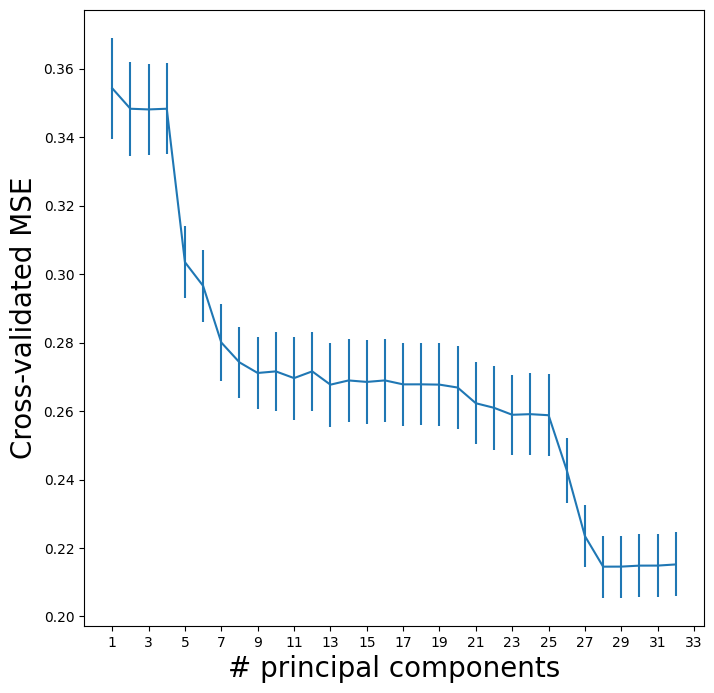

In [34]:
# Plot PCA Results - MSE for each potential number of components
pcr_fig, ax = subplots(figsize=(8,8))
n_comp = param_grid['pca__n_components']
ax.errorbar(n_comp, -grid.cv_results_['mean_test_score'], grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp[::2])

We don't really reduce the dimension of the features as the 28 componeets has the lowest MSE on the training dataset.

In [41]:
# Get the he explained variance ratios of the principal components
best_estimator = grid.best_estimator_
pca = best_estimator.named_steps['pca']
best_n_components = grid.best_params_['pca__n_components']
pca.n_components = best_n_components  
pca.fit(X_train_scaled) 
explained_variance = pca.explained_variance_ratio_
print("Explained variance ratios for each component:")
for i, ratio in enumerate(explained_variance):
    print(f"Component {i+1}: {ratio:.4f}")

Explained variance ratios for each component:
Component 1: 0.0923
Component 2: 0.0739
Component 3: 0.0591
Component 4: 0.0563
Component 5: 0.0522
Component 6: 0.0398
Component 7: 0.0371
Component 8: 0.0358
Component 9: 0.0345
Component 10: 0.0329
Component 11: 0.0322
Component 12: 0.0318
Component 13: 0.0318
Component 14: 0.0316
Component 15: 0.0315
Component 16: 0.0314
Component 17: 0.0314
Component 18: 0.0313
Component 19: 0.0313
Component 20: 0.0307
Component 21: 0.0296
Component 22: 0.0288
Component 23: 0.0260
Component 24: 0.0239
Component 25: 0.0186
Component 26: 0.0156
Component 27: 0.0130
Component 28: 0.0117


Here we can see more clearly that there are not any components that can explain most of the variability of the price. 

In [42]:
# Get Test MSE
predictions = grid.predict(X_test)
print(mean_squared_error(y_test, predictions))

0.1855338354570982


The test MSE is 0.18.

## Linear Regression with Regularization

In [46]:
# search for optimal alpha and l1_ratio
start_time = time.time()

elastic_net = ElasticNet(random_state=0)
param_grid_en = {'alpha': [0.1, 1, 10, 100], 'l1_ratio': np.arange(0.0, 1.0, 0.1)}
grid_search_en = GridSearchCV(elastic_net, param_grid_en, cv=kfold, scoring='neg_mean_squared_error')
grid_search_en.fit(X_train, y_train)
best_params = grid_search_en.best_params_
print("Best parameters found:", best_params)

# Create a new ElasticNet model with the best parameters
best_elastic_net = ElasticNet(alpha=best_params['alpha'], l1_ratio=best_params['l1_ratio'], random_state=0)

# Fit the best model on the entire training set
best_elastic_net.fit(X_train, y_train)

end_time = time.time()

elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time, "seconds")

/Users/yolanda/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.534e+02, tolerance: 2.262e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/yolanda/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.340e+02, tolerance: 2.192e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implem

Best parameters found: {'alpha': 0.1, 'l1_ratio': 0.0}
Coefficients: [-1.39923582e-02 -3.92223186e-03 -1.64555613e-03  6.37336379e-05
 -3.22613456e-03 -9.33996196e-05  4.05085721e-04  2.69250286e-01
 -1.36123888e-02 -8.60097501e-02 -1.69628147e-01  5.69724735e-02
 -7.75918461e-02  4.64652656e-02  9.21518084e-02 -2.29939170e-02
  3.88515215e-02 -2.19267256e-02 -2.35912835e-04 -4.80931346e-03
 -1.25844423e-02  6.11184003e-03 -1.60649978e-02 -2.32635983e-02
  1.39081764e-02 -1.70202426e-03  4.20192163e-03 -1.38488330e-02
 -7.30827087e-03  1.28110255e-02 -2.15139328e-02 -2.17843252e-02]
Intercept: 5.118127608392903


/Users/yolanda/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.603e+02, tolerance: 2.798e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


The best lambda found is 0.1 and ridge founds to be the best model. 

In [58]:
# Print MSE and Feature Importance from ElasticNet

y_pred_en = best_elastic_net.predict(X_test)
print("MSE from ElasticNet: ", mean_squared_error(y_test, y_pred_en))

feature_importance_en = np.abs(grid_search_en.best_estimator_.coef_)
important_features_en = np.argsort(feature_importance_en)[::-1]

feature_names = X_train.columns  

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance_en
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importances by Elastic Net Model:")
print(importance_df)


MSE from ElasticNet:  0.19705443771525646
Feature Importances by Elastic Net Model:
                           Feature  Importance
7        room_type_Entire home/apt    0.269250
10           room_type_Shared room    0.169628
14      district_Central & Western    0.092152
9           room_type_Private room    0.086010
12                  bathroom_count    0.077592
11                   bedroom_count    0.056972
13                       bed_count    0.046465
16                district_Islands    0.038852
23           district_Sham Shui Po    0.023264
15                district_Eastern    0.022994
17           district_Kowloon City    0.021927
31              district_Yuen Long    0.021784
30          district_Yau Tsim Mong    0.021514
22                district_Sha Tin    0.016065
0                         latitude    0.013992
24               district_Southern    0.013908
27               district_Tuen Mun    0.013849
8             room_type_Hotel room    0.013612
29           district_W

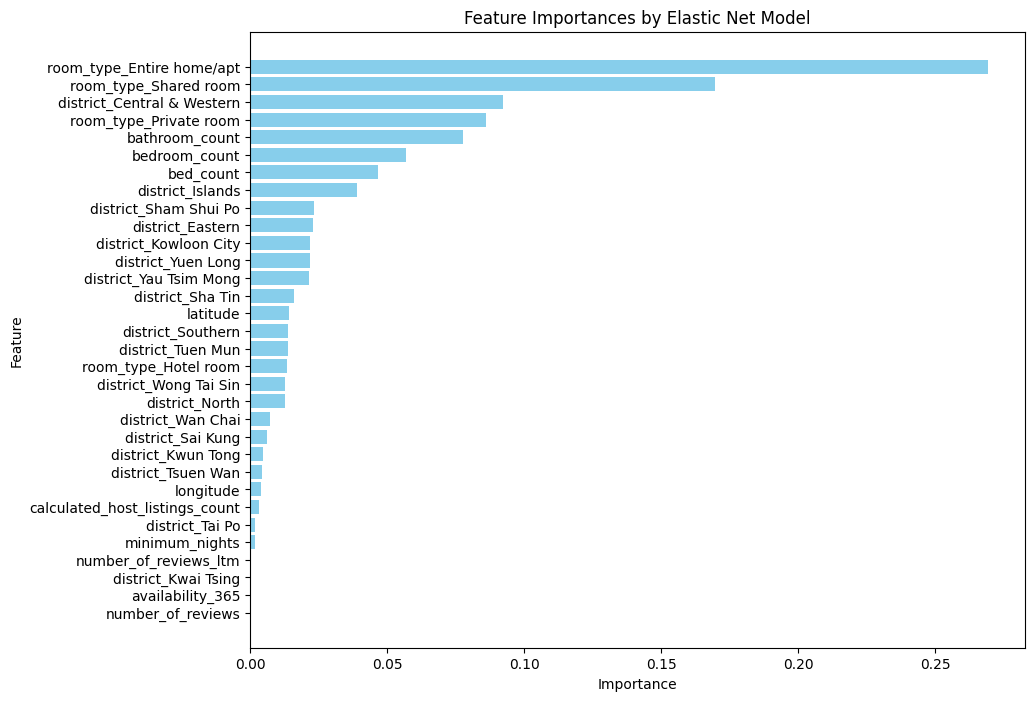

In [59]:
# Plot the feature importance
plt.figure(figsize=(10, 8))  # Set the figure size
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances by Elastic Net Model')
plt.gca().invert_yaxis()  # Invert y-axis to display most important feature on top
plt.show()

Test MSE is 0.197. The top 5 important features are number of reviews, room type as a private room, the number of beds, room type as a hotel. and the number of bedrooms.

## Gradient Boosting Model

In [50]:
from sklearn.ensemble import GradientBoostingRegressor as GBR
import time

In [52]:
# Find optimal num of estimators, depths, samples per splits while calculting the time 
start_time = time.time()

num_estimators = np.arange(20, 401, 40)
num_depths = np.arange(1,11,2)
num_samples_per_splits = np.arange(2,11,2)


param_grid = {'n_estimators': num_estimators, 
              'max_depth': num_depths,
              'min_samples_split': num_samples_per_splits
             }

boost = GBR()

kfold = skm.KFold(5,
                  shuffle=True,
                  random_state=10) 

grid = skm.GridSearchCV(boost,
                        param_grid,
                        refit=True,
                        cv=kfold, 
                        scoring='neg_mean_squared_error', 
                        n_jobs=-1) # n_jobs=-1 means use all available processors to parallelize

G = grid.fit(X_train, y_train)
end_time = time.time()

elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time, "seconds")

# Get the best parameters and test MSE
best_ = grid.best_estimator_
print(grid.best_params_, np.mean((y_test - best_.predict(X_test))**2))

Elapsed time: 285.247052192688 seconds
{'max_depth': 7, 'min_samples_split': 8, 'n_estimators': 140} 0.09051953035838975


When the tree-depth is 7, number of samples per split is 8, the best number of estimators is 140. we have the test MSE as 0.09. 

In [53]:
feature_importances = best_.feature_importances_

# Create DataFrame to show feature importances
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

                           Feature  Importance
4   calculated_host_listings_count    0.596592
7        room_type_Entire home/apt    0.091049
2                   minimum_nights    0.064266
0                         latitude    0.050310
1                        longitude    0.041480
11                   bedroom_count    0.036152
5                 availability_365    0.029931
13                       bed_count    0.027183
10           room_type_Shared room    0.014884
3                number_of_reviews    0.009915
12                  bathroom_count    0.008119
21               district_Sai Kung    0.007167
6            number_of_reviews_ltm    0.006569
9           room_type_Private room    0.002978
14      district_Central & Western    0.002752
15                district_Eastern    0.002605
8             room_type_Hotel room    0.001589
30          district_Yau Tsim Mong    0.001550
28               district_Wan Chai    0.001288
29           district_Wong Tai Sin    0.000803
17           

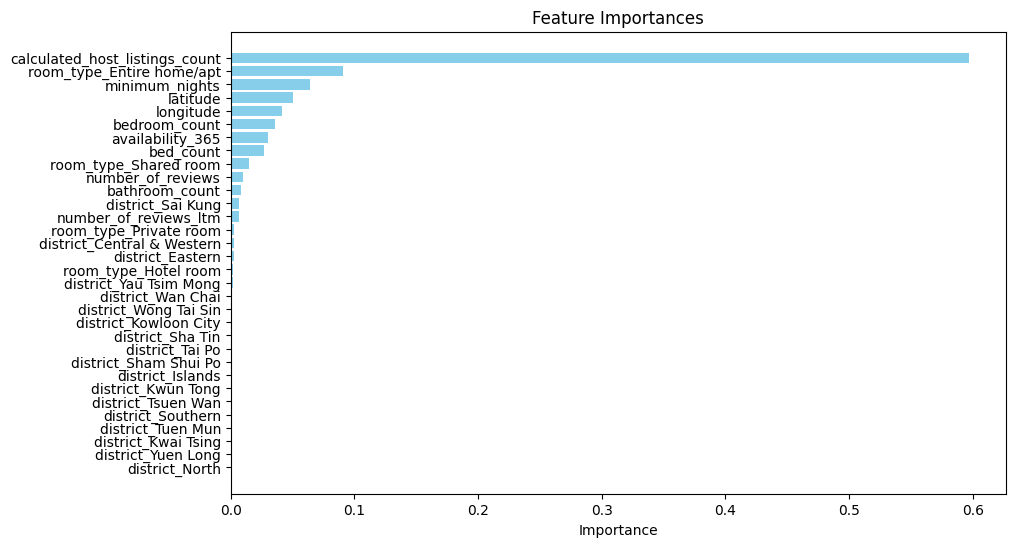

In [55]:
plt.figure(figsize=(10, 6))  # Set the figure size (width, height)
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')  # Label for the x-axis
plt.title('Feature Importances')  # Plot title
plt.gca().invert_yaxis()  # Invert y-axis to display most important feature on top
plt.show()

The most important features are calculated host listings count, room type as entire home/apartment, minimum nights, latitude, logitude, and  bedroom number.